In [4]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.grid_search import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
cd ../code

/Users/nicole/Documents/Galvanize/music-megahits/code


In [118]:
# import modules
import CleanData
import RunModel

In [7]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 200)
pd.options.mode.chained_assignment = None  # default='warn'

## Read in data

In [8]:
# read in data
df = pd.read_pickle('../data/BB_100_1955_EN_L_merged.pkl')
CleanData.print_counts(df)
# add relative features
df_sim = pd.read_pickle('../data/BB_100_1955_EN_L_merged_sim.pkl')
df_with_sim = pd.concat([df, df_sim], axis=1)
# clean data
df_clean = CleanData.clean_data(df_with_sim)

Number of obs:       29250
Number with EN:      24514  83.8%


## Select Features

In [9]:
X_cols = CleanData.select_features()

# 1980 - 2005 only

In [10]:
df_ml = CleanData.subset_by_year(df_clean, 1980, 2005)

### Logistic Regression

In [11]:
X_train, X_test, y_train, y_test = RunModel.prep_data(df_ml, 
                                                      X_cols,
                                                      scaled=True)
lr = LogisticRegression(C=1000)
RunModel.run_model(lr, X_train, X_test, y_train, y_test)
print ''
logit_coefs = RunModel.logit_results(lr, X_cols, max_predictors_to_print=15)

Counts for target buckets:
Number of hits: 1302
Number of non-hits: 1267

Accuracy:  0.653696498054
AUC: 0.686243217364

Top predictors:
sim_segment_loudness_sd: -4.824
sim_timbre_01_sd: 4.605
segment_loudness_sd: 4.602
timbre_01_sd: -4.515
sim_energy: -4.172
beats_confidence_mean: -3.932
sim_beats_confidence_mean: 3.887
energy: 3.823
sim_timbre_06_sd: -3.497
timbre_06_sd: 3.375
sim_tatums_confidence_mean: -2.203
tatums_confidence_mean: 2.202
sim_timbre_01_mean: 1.513
sim_bars_confidence_mean: -1.433
sim_timbre_03_sd: 1.241


### Random Forest

In [120]:
X_train, X_test, y_train, y_test = RunModel.prep_data(df_ml, X_cols, scaled=True)
rf = RandomForestClassifier(n_estimators=100, max_depth=5, max_features='auto')
y_prob_rf = RunModel.run_model(rf, X_train, X_test, y_train, y_test)
print ''
rf_importances = RunModel.random_forest_results(rf, X_cols, num_top_features=15)

Counts for target buckets:
Number of hits: 1302
Number of non-hits: 1267

Accuracy:  0.608949416342
AUC: 0.657851139179

Top features:
sim_instrumentalness: 0.059
sim_timbre_08_mean: 0.033
sim_beats_duration_sd: 0.029
timbre_08_sd: 0.024
timbre_02_mean: 0.021
sim_energy: 0.019
timbre_07_sd: 0.019
valence: 0.018
sim_beats_confidence_mean: 0.017
timbre_08_mean: 0.017
timbre_10_mean: 0.016
sim_valence: 0.015
sim_bars_confidence_mean: 0.015
timbre_02_sd: 0.015
sim_timbre_04_mean: 0.015


### Gradient Boosting

Counts for target buckets:
Number of hits: 1302
Number of non-hits: 1267

Accuracy:  0.647859922179
AUC: 0.699253720001

sim_instrumentalness        0.046556
sim_beats_duration_sd       0.028409
sim_bars_confidence_mean    0.020859
sim_liveness                0.020340
valence                     0.018825
duration                    0.018288
sim_speechiness             0.018026
sim_timbre_08_mean          0.017290
timbre_02_mean              0.016807
sim_tatums_duration_sd      0.016801
dtype: float64


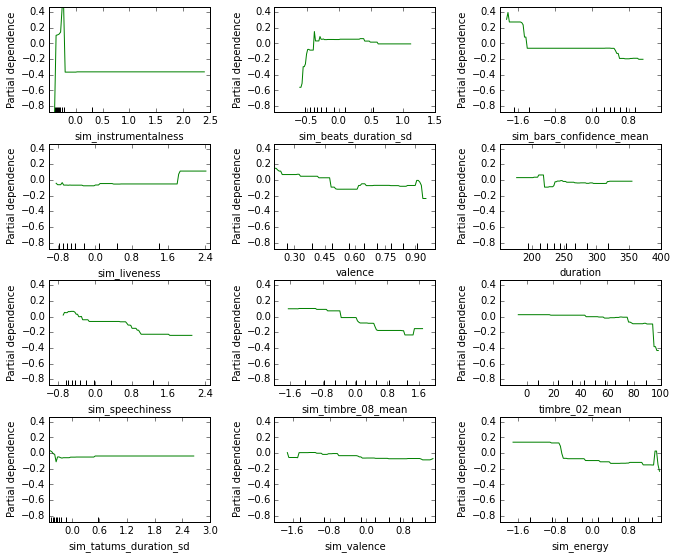

In [15]:
X_train, X_test, y_train, y_test = RunModel.prep_data(df_ml, X_cols)
gdbc = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, max_features=1.0,
                                  min_samples_leaf=1, n_estimators=100, random_state=100)
y_prob = RunModel.run_model(gdbc, X_train, X_test, y_train, y_test)
print ''
importances = RunModel.grad_boost_classifier_results(gdbc, X_train, 
                                                     X_cols, 
                                                     num_top_features=12)
print importances[:10]

In [16]:
importances = pd.Series(gdbc.feature_importances_, index=X_cols)
importances.sort(ascending=False)
dict_col_names = {'sim_bars_confidence_mean':'Rhythmic Simplicity (Relative)', 
                  'sim_instrumentalness':'Instrumentalness (Relative)',
                  'sim_beats_duration_sd': 'Change in Tempo (Relative)',
                  'sim_liveness':'Liveness (Relative)',
                  'valence': 'Emotional Tone/Positivity',
                  'duration': 'Duration'}
X_cols_for_graphs = [dict_col_names.get(x, x) for x in X_cols]

In [53]:
# set font size
#plt.rcParams.update({'font.size': 18})

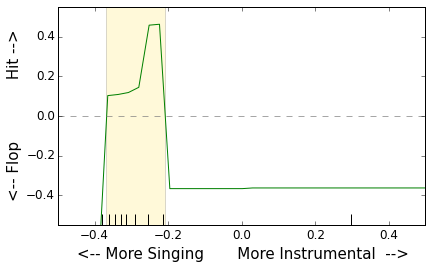

In [110]:
feature_name = importances.index[0]
feature_index = [X_cols.index(feature_name)]

fig,axs = plot_partial_dependence(gdbc, X_train, feature_index, feature_names=X_cols_for_graphs)
fig.set_size_inches(6, 5.5)
partdep = axs[0]
partdep.set_xlim([-.5,.5])
partdep.set_ylim([-.55, .55])
plt.axhline(0, color='grey', linestyle='--', alpha=.7)
plt.axvspan(-.37, -.21, facecolor='gold', alpha=0.15)
plt.xlabel("<-- More Singing       More Instrumental  -->", fontsize=15)
plt.ylabel("<-- Flop             Hit -->", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

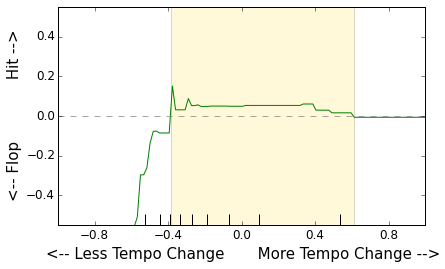

In [111]:
feature_name = importances.index[1]
feature_index = [X_cols.index(feature_name)]

fig,axs = plot_partial_dependence(gdbc, X_train, feature_index, feature_names=X_cols_for_graphs)
fig.set_size_inches(6, 5.5)
partdep = axs[0]
partdep.set_xlim([-1,1])
partdep.set_ylim([-.55, .55])
plt.axhline(0, color='grey', linestyle='--', alpha=.7)
plt.axvspan(-.388, .61, facecolor='gold', alpha=0.15)
plt.xlabel("<-- Less Tempo Change       More Tempo Change -->", fontsize=15)
plt.ylabel("<-- Flop             Hit -->", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

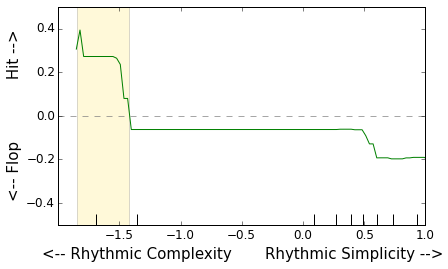

In [117]:
feature_name = importances.index[2]
feature_index = [X_cols.index(feature_name)]

fig,axs = plot_partial_dependence(gdbc, X_train, feature_index, feature_names=X_cols_for_graphs)
fig.set_size_inches(6, 5.5)
partdep = axs[0]
partdep.set_xlim([-2,1])
partdep.set_ylim([-.5, .5])
plt.axhline(0, color='grey', linestyle='--', alpha=.7)
plt.axvspan(-1.85, -1.42, facecolor='gold', alpha=0.15)
plt.xlabel("<-- Rhythmic Complexity       Rhythmic Simplicity -->", fontsize=15)
plt.ylabel("<-- Flop             Hit -->", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

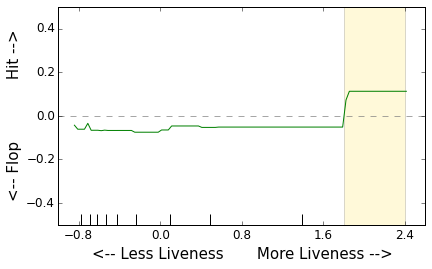

In [116]:
feature_name = importances.index[3]
feature_index = [X_cols.index(feature_name)]

fig,axs = plot_partial_dependence(gdbc, X_train, feature_index, feature_names=X_cols_for_graphs)
fig.set_size_inches(6, 5.5)
partdep = axs[0]
partdep.set_xlim([-1,2.6])
partdep.set_ylim([-.5, .5])
plt.axhline(0, color='grey', linestyle='--', alpha=.7)
plt.axvspan(1.8, 2.4, facecolor='gold', alpha=0.15)
plt.xlabel("<-- Less Liveness       More Liveness -->", fontsize=15)
plt.ylabel("<-- Flop             Hit -->", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

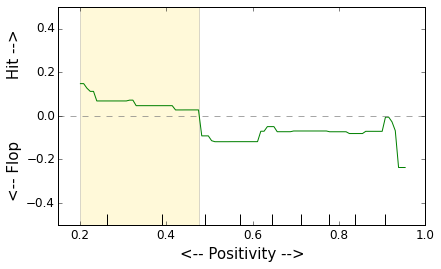

In [114]:
feature_name = importances.index[4]
feature_index = [X_cols.index(feature_name)]

fig,axs = plot_partial_dependence(gdbc, X_train, feature_index, feature_names=X_cols_for_graphs)
fig.set_size_inches(6, 5.5)
partdep = axs[0]
partdep.set_xlim([0.15,1])
partdep.set_ylim([-.5, .5])
plt.axhline(0, color='grey', linestyle='--', alpha=.7)
plt.axvspan(.2, .475, facecolor='gold', alpha=0.15)
plt.xlabel("<-- Positivity -->", fontsize=15)
plt.ylabel("<-- Flop             Hit -->", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

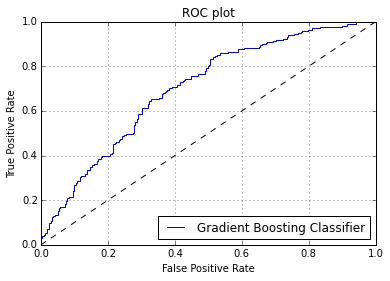

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# ROC Curve
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.array(range(101))/100, np.array(range(101))/100, '--', color='black')
plt.plot(fpr, tpr, label='Gradient Boosting Classifier')
plt.ylabel("True Positive Rate ")
plt.xlabel("False Positive Rate")
plt.title("ROC plot")
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [29]:
y_pred = [1 if prob > .5 else 0 for prob in y_prob]
true_pos = sum([(test == 1) & (pred == 1) for test, pred in zip(y_test, y_pred)])
true_neg = sum([(test == 0) & (pred == 0) for test, pred in zip(y_test, y_pred)])
false_pos = sum([(test == 0) & (pred == 1) for test, pred in zip(y_test, y_pred)])
false_neg = sum([(test == 1) & (pred == 0) for test, pred in zip(y_test, y_pred)])
total = float(len(y_test))

print true_pos/total, true_neg/total
print false_pos/total, false_neg/total
print 'Total N:', int(total)

0.357976653696 0.29766536965
0.171206225681 0.173151750973
Total N: 514
